# Simulate a user accessing scenes to estimate # of sectors needed to unseal

## Imports

In [6]:
%matplotlib inline
import random
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999

## User Settings

In [56]:
number_of_requests = 1000
iterations = 20

## Sector and Cache Settings

In [8]:
# cache_time = 1000 # Number of requests (loops) before hot storage cache is cleared
# cache_hit_count = 0
sector_scene_count = 25
sector_packing_method = ""

## Prepare Landsat scenes (Rows/Paths) of the US

### Fetch files

[Landsat Descending Path/Row shapefile](https://www.usgs.gov/media/files/landsat-wrs-2-descending-path-row-shapefile)

[US States boundaries 20m:1 shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

[MSA boundaries 20m:1 shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

In [9]:
landsat_scenes_shp = gpd.read_file("https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip")[["PATH", "ROW", "geometry"]]
us_states_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")[["geometry", "STUSPS"]]
msa_boundaries = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_cbsa_20m.zip")[["CBSAFP", "geometry"]]

### Reproject to WGS84 (to match Landsat)

In [10]:
us_states_shp.to_crs(epsg=4326, inplace=True)
msa_boundaries.to_crs(epsg=4326, inplace=True)

### Clip Scenes to Continential US 

In [11]:
us_states_continential = us_states_shp[us_states_shp["STUSPS"].isin(["AK", "HI", "PR", "VI", "GU", "AS", "MP", "UM"]) == False] # Remove non-continental US states
landsat_scenes_clipped = gpd.clip(landsat_scenes_shp, us_states_continential)
len(landsat_scenes_clipped) # Should be about 457 scenes
landsat_scenes_clipped.reset_index(inplace=True, drop=True) # Reset index because we clipped the dataframe

c:\Users\jsoll\Documents\easier\venv\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


## Plot the scenes Path/Row with labels

<AxesSubplot: >

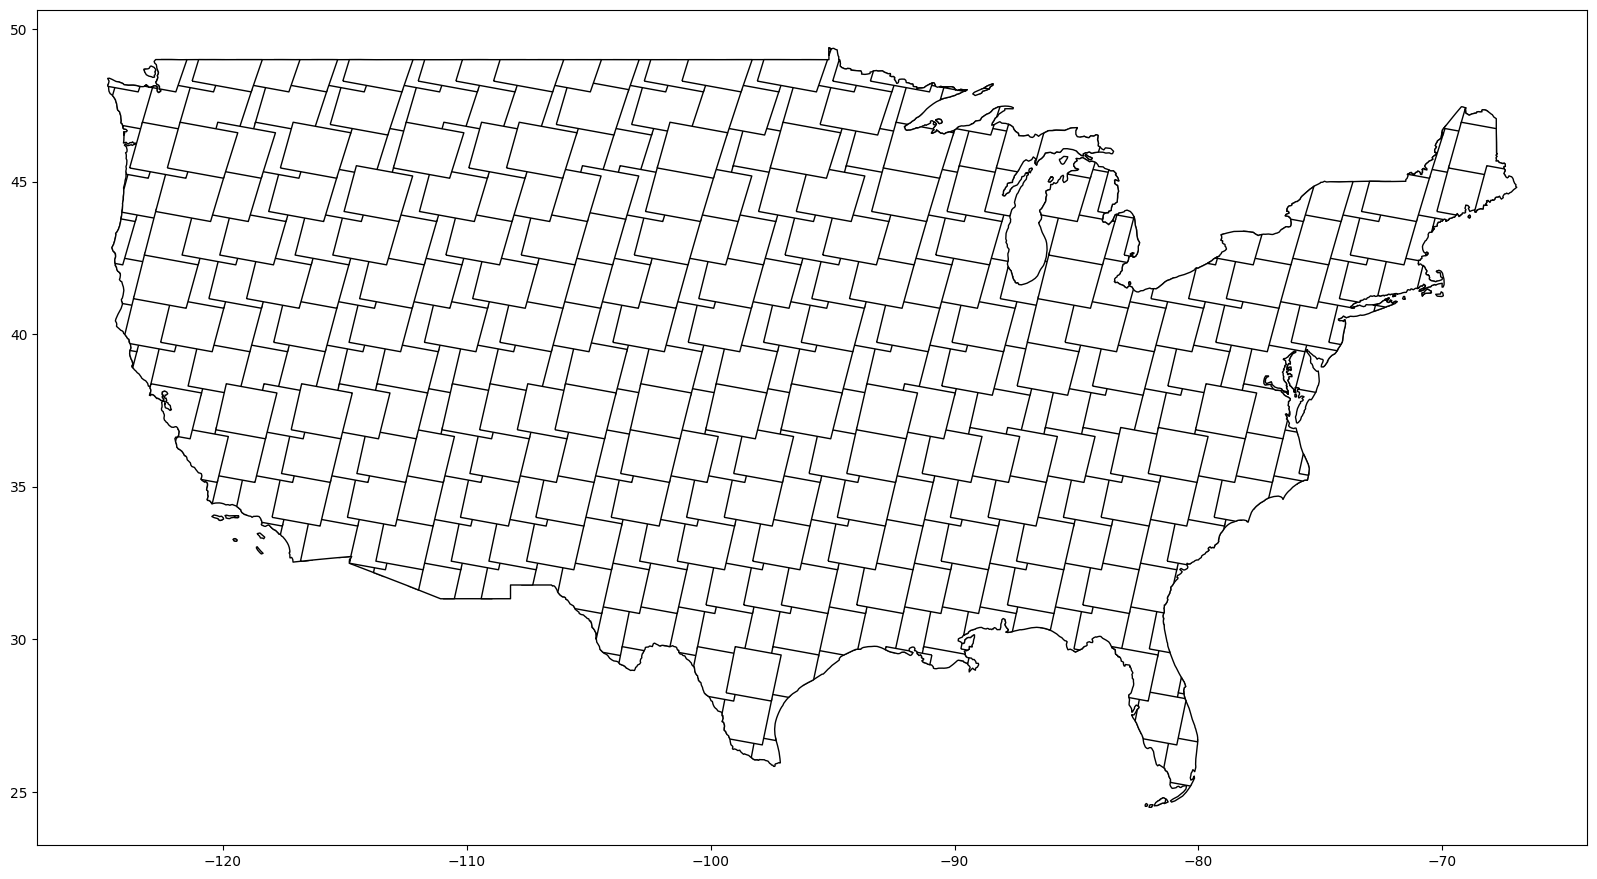

In [12]:
## Plot the scenes Path/Row
landsat_scenes_clipped.plot(figsize=(20, 20), color="white", edgecolor="black")

## Pack Sectors (nearest neighbors, sequential)

In [47]:
landsat_scenes_clipped_with_sectors = landsat_scenes_clipped.copy()
scenes = landsat_scenes_clipped_with_sectors[["PATH", "ROW"]].sort_values(by=["PATH", "ROW"]).values

def array_present_in_array(array, array_to_check):
    """Check if an array is present in another array"""
    if (array == array_to_check).all(1).any():
        return True

car_scenes = {}

curr_indx = 0
 # While there are still scenes to be assigned to sectors
while len(scenes) > 0:
    current_sector = f"Sector {curr_indx}"
    if len(scenes) < sector_scene_count:
        car_scenes[current_sector] = scenes
        break

    tree = KDTree(scenes)
    scene_to_query = scenes[0]
    nearest_scene_indices = tree.query(scene_to_query, k=25)[1]
    nearest_scenes = scenes[nearest_scene_indices]

    car_scenes[current_sector] = nearest_scenes
    # Remove the scenes that were assigned to the sector
    scenes = np.delete(scenes, nearest_scene_indices, axis=0)
    curr_indx += 1

## Pack the sectors (Naive)

In [30]:
landsat_scenes_clipped_with_sectors = landsat_scenes_clipped.copy()
scenes = landsat_scenes_clipped_with_sectors[["PATH", "ROW"]].values

car_scenes = {}
curr_indx = 0
while len(scenes) > 0:
    current_sector = f"Sector {curr_indx}"
    if len(scenes) < sector_scene_count:
        car_scenes[current_sector] = scenes
        break

    car_scenes[current_sector] = scenes[:sector_scene_count]
    scenes = scenes[sector_scene_count:] # Remove the scenes that were assigned to the sector
    curr_indx += 1

In [31]:
car_scenes

{'Sector 0': array([[12, 28],
        [21, 28],
        [22, 27],
        [13, 27],
        [12, 27],
        [48, 27],
        [47, 27],
        [48, 26],
        [33, 28],
        [31, 28],
        [30, 28],
        [28, 28],
        [27, 28],
        [34, 28],
        [25, 28],
        [24, 28],
        [27, 27],
        [23, 27],
        [34, 27],
        [30, 27],
        [31, 27],
        [29, 27],
        [24, 27],
        [28, 27],
        [32, 27]], dtype=int64),
 'Sector 1': array([[26, 27],
        [33, 27],
        [25, 27],
        [31, 26],
        [29, 26],
        [26, 26],
        [34, 26],
        [28, 26],
        [25, 26],
        [33, 26],
        [30, 26],
        [32, 26],
        [27, 26],
        [35, 26],
        [30, 25],
        [10, 28],
        [11, 27],
        [40, 28],
        [35, 28],
        [41, 28],
        [44, 27],
        [40, 27],
        [36, 27],
        [37, 27],
        [42, 27]], dtype=int64),
 'Sector 2': array([[41, 27],
        [43, 27]

## This is NOT efficient, but it works (Assign scenes to sectors)

In [48]:
def array_present_in_array(array, array_to_check):
    """Check if an array is present in another array"""
    if (array == array_to_check).all(1).any():
        return True

add_sector_to_scene = landsat_scenes_clipped_with_sectors.copy()
for sector in car_scenes.items():
    for row in add_sector_to_scene.itertuples():
        if sector[0] == "Sector 17" and row.PATH == 32 and row.ROW == 32:
            pass
        if array_present_in_array(np.array([row.PATH, row.ROW]), sector[1]):
            add_sector_to_scene.at[row.Index, "Sector"] = sector[0]

In [15]:
"""
The last CAR file will often have less than 25 scenes that are not necessarily neighbors. This is because the last CAR file will be packed with the remaining scenes.
"""
print(len(car_scenes))

19


## Intersect MSAs Landsat Scenes tagged with Sector ID

In [49]:
msa_boundaries_intersect= gpd.sjoin(msa_boundaries, add_sector_to_scene, how="inner", op="intersects").sort_values(by="Sector")

c:\Users\jsoll\Documents\easier\venv\lib\site-packages\IPython\core\interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<AxesSubplot: >

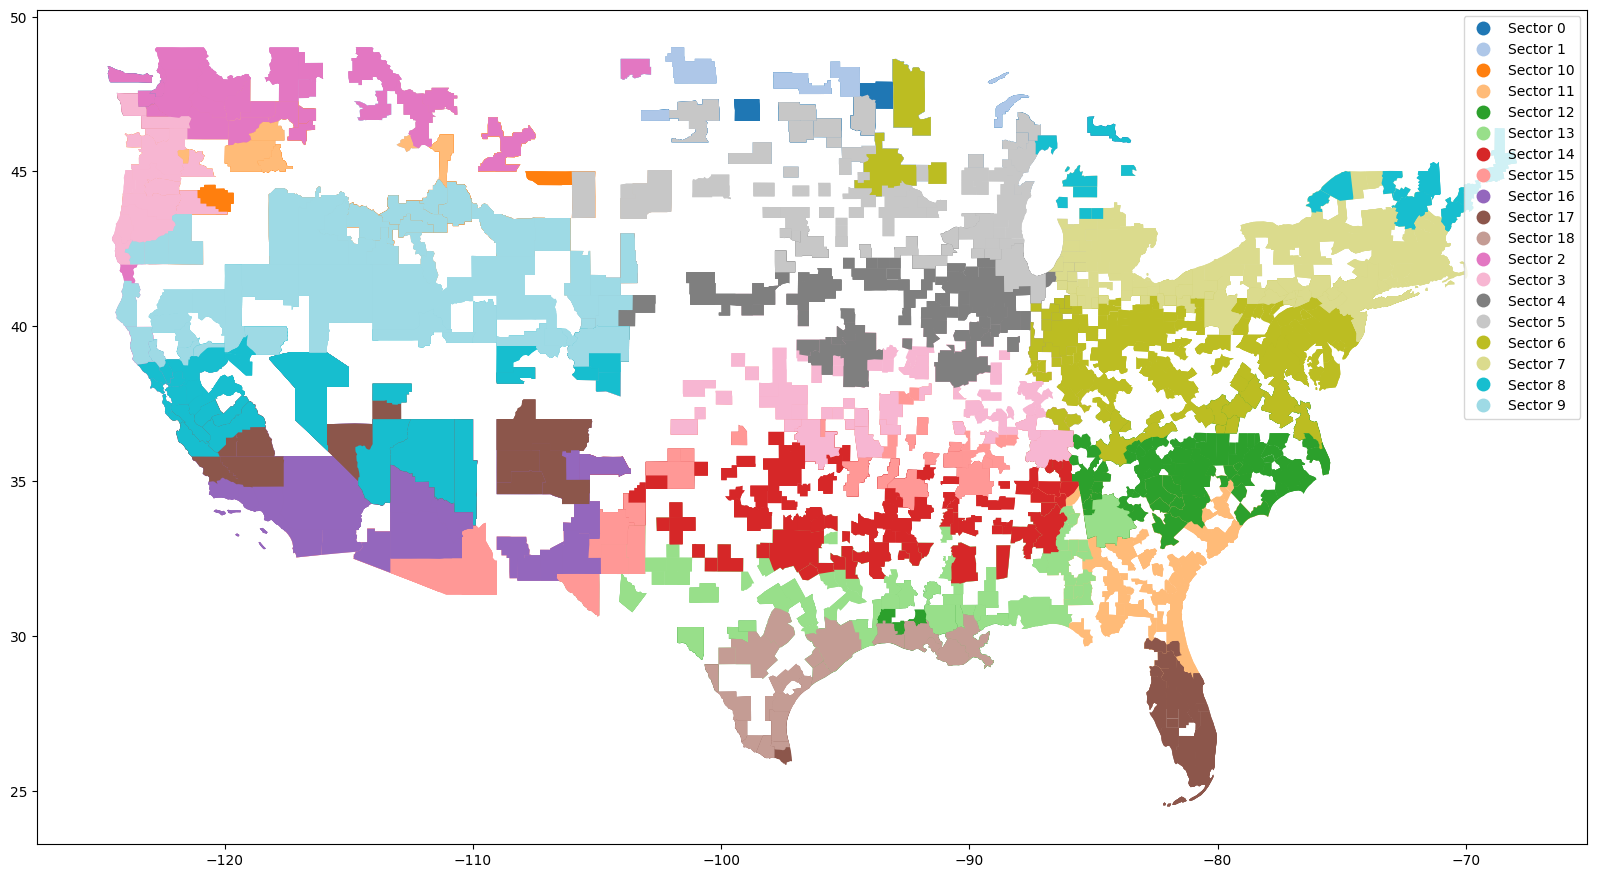

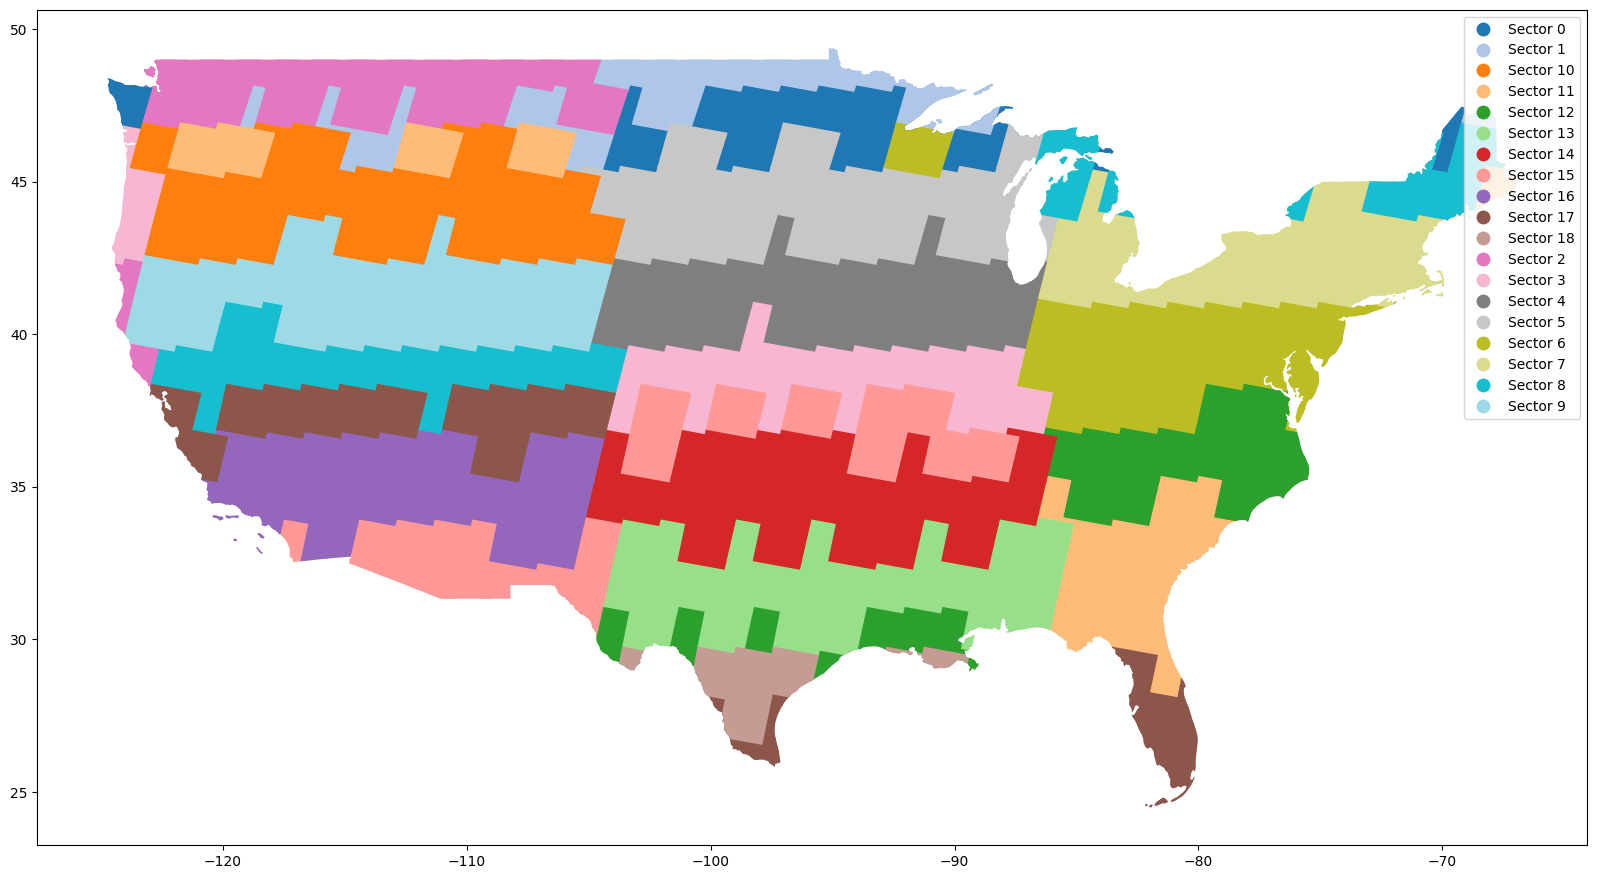

In [34]:
# Plot the MSAs and the number of sectors in each MSA
msa_boundaries_intersect.plot(column="Sector", figsize=(20, 20), cmap='tab20', legend=True)
add_sector_to_scene.plot(column="Sector", figsize=(20, 20), cmap='tab20', legend=True)

## Simulate User Access

In [60]:
def get_sector_hit_count(msa_boundaries, number_of_requests):
    sector_hit_dict = {
    "Sector 0": 0,
    "Sector 1": 0,
    "Sector 2": 0,
    "Sector 3": 0,
    "Sector 4": 0,
    "Sector 5": 0,
    "Sector 6": 0,
    "Sector 7": 0,
    "Sector 8": 0,
    "Sector 9": 0,
    "Sector 10": 0,
    "Sector 11": 0,
    "Sector 12": 0,
    "Sector 13": 0,
    "Sector 14": 0,
    "Sector 15": 0,
    "Sector 16": 0,
    "Sector 17": 0,
    "Sector 18": 0,
}
    for i in range(number_of_requests):
        random_msa = random.choice(msa_boundaries["CBSAFP"].values)
        sectors = msa_boundaries_intersect[msa_boundaries_intersect["CBSAFP"] == random_msa]["Sector"].values
        for sector in sectors:
            sector_hit_dict[sector] += 1

    return sum(sector_hit_dict.values())


average_number_of_sectors_hit = sum([get_sector_hit_count(msa_boundaries_intersect, number_of_requests) for i in range(iterations)]) / iterations
average_number_of_sectors_hit


NameError: name 'mean' is not defined

## Plot Results